In [1]:
# load csv file and print the first 5 rows
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

#df = pd.read_csv('datasets/target_model/CICIDS2017/combined_data_new_noSMOTE_0307_1.csv') # datasets\target_model\CICIDS2017\combined_data_0307_1.csv
# df


In [2]:
# X = df.iloc[:, 0:-1]
# y = df.iloc[:, -1]


In [3]:
# from sklearn.model_selection import train_test_split

# # Split into train+val and test
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# # Split train into train-val
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [4]:
traindata = pd.read_csv('../datasets/target_model/CICIDS2017/X_train.csv') 
valdata = pd.read_csv('../datasets/target_model/CICIDS2017/X_val.csv')
testdata = pd.read_csv('../datasets/target_model/CICIDS2017/X_test.csv')
data = pd.concat([traindata, valdata, testdata], axis=0)
X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

In [5]:
X_train = traindata.iloc[:, 0:-1]
y_train = traindata.iloc[:, -1]
X_val = valdata.iloc[:, 0:-1]
y_val = valdata.iloc[:, -1]
X_test = testdata.iloc[:, 0:-1]
y_test = testdata.iloc[:, -1]

In [6]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [7]:
# # no use for now
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# class ClassifierDataset(Dataset):
    
#     def __init__(self, X_data, y_data):
#         self.X_data = X_data
#         self.y_data = y_data
        
#     def __getitem__(self, index):
#         return self.X_data[index], self.y_data[index]
        
#     def __len__ (self):
#         print(type(self.X_data))
#         return len(self.X_data)


# train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
# val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
# test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [8]:
## create dataloaders by myself
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_dataset = ClassifierDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_dataset = ClassifierDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())

In [9]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
NUM_FEATURES = len(X.columns)
NUM_CLASSES = y.nunique()

In [10]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [11]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [12]:
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

###################### OUTPUT ######################
cuda:0

cpu


In [13]:
from torch import optim

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=42, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [14]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [15]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [16]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from datetime import datetime

print("Begin training.")
best_vloss = 1000000
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_acc_score = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        #print("train_data: ", X_train_batch, y_train_batch)
        # print train data shape  
        # X_train_batch:  torch.Size([64, 42]) y_train_batch torch.Size([64]) 
        # X_train_batch:  torch.Size([batch size, feature size]) y_train_batch torch.Size([batch size])
        #print("X_train_batch: ", X_train_batch.shape, "y_train_batch", y_train_batch.shape)
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        #print("X_train_batch: ", X_train_batch, "y_train_batch", y_train_batch)
        y_train_pred = model(X_train_batch)
        #print("y_train_pred: ", y_train_pred, y_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        # caculate train accuracy score from python package
        _, y_train_pred_tags = torch.max( y_train_pred, dim = 1)
        y_train_pred_tags.cpu().numpy()
        #train_acc_score = accuracy_score(y_train_batch,  y_train_pred_tags)
        #print("train_acc_score: ", train_acc_score)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        #train_epoch_acc_score += train_acc_score
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            #print("val_data: ", X_val_batch, y_val_batch)
            y_val_pred = model(X_val_batch)
            # print("y_val_pred: ", y_val_pred, y_val_batch)          
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    avg_vloss = val_epoch_loss/len(val_loader)       
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../target_model/target_DNN_model/binaryclass/targetDNN_model_{}_{}'.format(timestamp, EPOCHS) # target_model\target_DNN_model\binaryclass
        torch.save(model.state_dict(), model_path)                           
        torch.save(model, model_path + '.pt')    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    #print(f'Epoch {e+0:03}: | Train Acc: {train_epoch_acc_score/len(train_loader):.3f}')

Begin training.


  2%|▏         | 1/50 [00:34<28:06, 34.41s/it]

Epoch 001: | Train Loss: 0.29044 | Val Loss: 0.23687 | Train Acc: 90.091| Val Acc: 91.810


  4%|▍         | 2/50 [01:08<27:31, 34.41s/it]

Epoch 002: | Train Loss: 0.23233 | Val Loss: 0.24784 | Train Acc: 91.678| Val Acc: 93.028


  6%|▌         | 3/50 [01:43<26:57, 34.40s/it]

Epoch 003: | Train Loss: 0.20874 | Val Loss: 0.25737 | Train Acc: 92.315| Val Acc: 93.590


  8%|▊         | 4/50 [02:17<26:24, 34.45s/it]

Epoch 004: | Train Loss: 0.19016 | Val Loss: 0.32536 | Train Acc: 92.928| Val Acc: 93.944


 10%|█         | 5/50 [02:52<25:50, 34.46s/it]

Epoch 005: | Train Loss: 0.18072 | Val Loss: 0.37074 | Train Acc: 93.278| Val Acc: 93.814


 12%|█▏        | 6/50 [03:26<25:15, 34.44s/it]

Epoch 006: | Train Loss: 0.17662 | Val Loss: 0.41826 | Train Acc: 93.423| Val Acc: 93.654


 14%|█▍        | 7/50 [04:01<24:40, 34.43s/it]

Epoch 007: | Train Loss: 0.17103 | Val Loss: 0.58695 | Train Acc: 93.557| Val Acc: 93.090


 16%|█▌        | 8/50 [04:35<24:07, 34.45s/it]

Epoch 008: | Train Loss: 0.16746 | Val Loss: 0.59010 | Train Acc: 93.646| Val Acc: 94.272


 18%|█▊        | 9/50 [05:09<23:32, 34.45s/it]

Epoch 009: | Train Loss: 0.16625 | Val Loss: 0.58274 | Train Acc: 93.633| Val Acc: 92.811


 20%|██        | 10/50 [05:44<22:58, 34.46s/it]

Epoch 010: | Train Loss: 0.16393 | Val Loss: 0.55293 | Train Acc: 93.721| Val Acc: 92.743


 22%|██▏       | 11/50 [06:19<22:32, 34.68s/it]

Epoch 011: | Train Loss: 0.15963 | Val Loss: 0.61291 | Train Acc: 93.813| Val Acc: 91.699


 24%|██▍       | 12/50 [06:54<21:57, 34.66s/it]

Epoch 012: | Train Loss: 0.15782 | Val Loss: 0.64979 | Train Acc: 93.823| Val Acc: 92.008


 26%|██▌       | 13/50 [07:29<21:27, 34.79s/it]

Epoch 013: | Train Loss: 0.15608 | Val Loss: 0.60562 | Train Acc: 93.835| Val Acc: 91.237


 28%|██▊       | 14/50 [08:04<20:59, 35.00s/it]

Epoch 014: | Train Loss: 0.15397 | Val Loss: 0.53212 | Train Acc: 93.928| Val Acc: 91.195


 30%|███       | 15/50 [08:38<20:15, 34.71s/it]

Epoch 015: | Train Loss: 0.15431 | Val Loss: 0.73454 | Train Acc: 93.905| Val Acc: 91.365


 32%|███▏      | 16/50 [09:13<19:40, 34.72s/it]

Epoch 016: | Train Loss: 0.15284 | Val Loss: 0.76132 | Train Acc: 93.952| Val Acc: 91.067


 34%|███▍      | 17/50 [09:47<18:59, 34.53s/it]

Epoch 017: | Train Loss: 0.15136 | Val Loss: 0.94557 | Train Acc: 93.950| Val Acc: 91.016


 36%|███▌      | 18/50 [10:21<18:19, 34.36s/it]

Epoch 018: | Train Loss: 0.15066 | Val Loss: 0.81186 | Train Acc: 93.970| Val Acc: 91.148


 38%|███▊      | 19/50 [10:55<17:40, 34.23s/it]

Epoch 019: | Train Loss: 0.14916 | Val Loss: 0.92032 | Train Acc: 93.970| Val Acc: 91.859


 40%|████      | 20/50 [11:29<17:04, 34.14s/it]

Epoch 020: | Train Loss: 0.14803 | Val Loss: 0.96030 | Train Acc: 94.036| Val Acc: 91.631


 42%|████▏     | 21/50 [12:03<16:27, 34.06s/it]

Epoch 021: | Train Loss: 0.14676 | Val Loss: 1.19408 | Train Acc: 94.068| Val Acc: 91.371


 44%|████▍     | 22/50 [12:37<15:54, 34.10s/it]

Epoch 022: | Train Loss: 0.14573 | Val Loss: 1.03286 | Train Acc: 94.090| Val Acc: 91.286


 46%|████▌     | 23/50 [13:12<15:23, 34.22s/it]

Epoch 023: | Train Loss: 0.14507 | Val Loss: 1.19010 | Train Acc: 94.097| Val Acc: 91.256


 48%|████▊     | 24/50 [13:46<14:53, 34.36s/it]

Epoch 024: | Train Loss: 0.14561 | Val Loss: 0.98843 | Train Acc: 94.117| Val Acc: 91.776


 50%|█████     | 25/50 [14:22<14:32, 34.88s/it]

Epoch 025: | Train Loss: 0.14496 | Val Loss: 1.08788 | Train Acc: 94.104| Val Acc: 90.882


 52%|█████▏    | 26/50 [14:57<13:56, 34.84s/it]

Epoch 026: | Train Loss: 0.14559 | Val Loss: 1.11056 | Train Acc: 94.077| Val Acc: 91.092


 54%|█████▍    | 27/50 [15:31<13:12, 34.46s/it]

Epoch 027: | Train Loss: 0.14437 | Val Loss: 1.14236 | Train Acc: 94.139| Val Acc: 91.037


 56%|█████▌    | 28/50 [16:04<12:31, 34.17s/it]

Epoch 028: | Train Loss: 0.14401 | Val Loss: 1.09492 | Train Acc: 94.166| Val Acc: 90.483


 58%|█████▊    | 29/50 [16:38<11:53, 33.96s/it]

Epoch 029: | Train Loss: 0.14324 | Val Loss: 1.17069 | Train Acc: 94.180| Val Acc: 90.958


 60%|██████    | 30/50 [17:11<11:16, 33.81s/it]

Epoch 030: | Train Loss: 0.14223 | Val Loss: 1.25334 | Train Acc: 94.189| Val Acc: 91.156


 62%|██████▏   | 31/50 [17:45<10:40, 33.71s/it]

Epoch 031: | Train Loss: 0.14146 | Val Loss: 1.69456 | Train Acc: 94.221| Val Acc: 91.195


 64%|██████▍   | 32/50 [18:19<10:08, 33.82s/it]

Epoch 032: | Train Loss: 0.14186 | Val Loss: 1.38625 | Train Acc: 94.226| Val Acc: 90.943


 66%|██████▌   | 33/50 [18:53<09:37, 33.98s/it]

Epoch 033: | Train Loss: 0.14153 | Val Loss: 1.48265 | Train Acc: 94.262| Val Acc: 90.716


 68%|██████▊   | 34/50 [19:27<09:05, 34.12s/it]

Epoch 034: | Train Loss: 0.13927 | Val Loss: 1.36109 | Train Acc: 94.292| Val Acc: 91.161


 70%|███████   | 35/50 [20:01<08:29, 33.96s/it]

Epoch 035: | Train Loss: 0.14002 | Val Loss: 1.29320 | Train Acc: 94.264| Val Acc: 91.005


 72%|███████▏  | 36/50 [20:35<07:53, 33.82s/it]

Epoch 036: | Train Loss: 0.13917 | Val Loss: 1.48445 | Train Acc: 94.315| Val Acc: 90.888


 74%|███████▍  | 37/50 [21:08<07:18, 33.72s/it]

Epoch 037: | Train Loss: 0.13838 | Val Loss: 1.32196 | Train Acc: 94.310| Val Acc: 90.901


 76%|███████▌  | 38/50 [21:41<06:43, 33.65s/it]

Epoch 038: | Train Loss: 0.13812 | Val Loss: 1.42971 | Train Acc: 94.318| Val Acc: 91.663


 78%|███████▊  | 39/50 [22:15<06:09, 33.63s/it]

Epoch 039: | Train Loss: 0.13740 | Val Loss: 1.43187 | Train Acc: 94.378| Val Acc: 91.011


 80%|████████  | 40/50 [22:49<05:35, 33.60s/it]

Epoch 040: | Train Loss: 0.13699 | Val Loss: 1.38720 | Train Acc: 94.412| Val Acc: 90.911


 82%|████████▏ | 41/50 [23:22<05:02, 33.61s/it]

Epoch 041: | Train Loss: 0.13732 | Val Loss: 1.31118 | Train Acc: 94.391| Val Acc: 91.497


 84%|████████▍ | 42/50 [23:56<04:29, 33.66s/it]

Epoch 042: | Train Loss: 0.13435 | Val Loss: 1.35018 | Train Acc: 94.458| Val Acc: 91.322


 86%|████████▌ | 43/50 [24:30<03:55, 33.67s/it]

Epoch 043: | Train Loss: 0.13511 | Val Loss: 1.34398 | Train Acc: 94.402| Val Acc: 91.303


 88%|████████▊ | 44/50 [25:03<03:21, 33.66s/it]

Epoch 044: | Train Loss: 0.13553 | Val Loss: 1.48714 | Train Acc: 94.424| Val Acc: 91.271


 90%|█████████ | 45/50 [25:37<02:48, 33.67s/it]

Epoch 045: | Train Loss: 0.13446 | Val Loss: 1.69314 | Train Acc: 94.493| Val Acc: 91.107


 92%|█████████▏| 46/50 [26:11<02:14, 33.67s/it]

Epoch 046: | Train Loss: 0.13367 | Val Loss: 1.60969 | Train Acc: 94.618| Val Acc: 91.471


 94%|█████████▍| 47/50 [26:44<01:41, 33.70s/it]

Epoch 047: | Train Loss: 0.13306 | Val Loss: 1.46962 | Train Acc: 94.618| Val Acc: 90.971


 96%|█████████▌| 48/50 [27:18<01:07, 33.69s/it]

Epoch 048: | Train Loss: 0.13345 | Val Loss: 1.39256 | Train Acc: 94.587| Val Acc: 90.750


 98%|█████████▊| 49/50 [27:52<00:33, 33.73s/it]

Epoch 049: | Train Loss: 0.13317 | Val Loss: 1.19181 | Train Acc: 94.673| Val Acc: 90.945


100%|██████████| 50/50 [28:26<00:00, 34.13s/it]

Epoch 050: | Train Loss: 0.13335 | Val Loss: 1.31335 | Train Acc: 94.673| Val Acc: 91.644


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

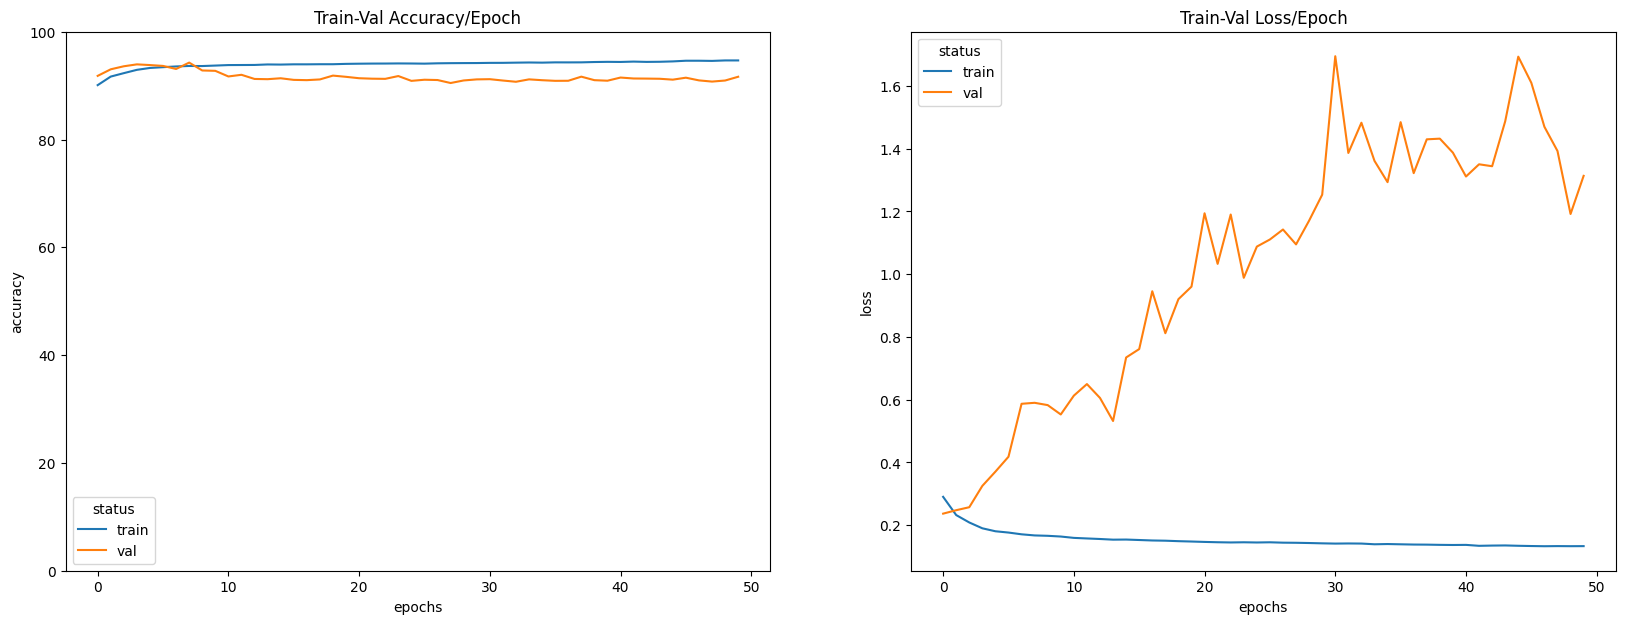

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# modify column names
train_val_acc_df.columns = ['epochs', 'status', 'accuracy']
train_val_loss_df.columns = ['epochs', 'status', 'loss']
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="accuracy", hue="status",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
# change the limits of y-axis
axes[0].set_ylim(0, 100) 
sns.lineplot(data=train_val_loss_df, x = "epochs", y="loss", hue="status", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [18]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        #print(_, y_pred_tags.cpu().numpy())
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [19]:
y_test.shape

(117400,)

In [20]:
len(y_pred_list)

117400

In [21]:
# test accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(y_test, y_pred_list))

0.9165587734241908


In [22]:
y_test = y_test
print(classification_report(y_test, y_pred_list, target_names=['Benign', 'Malicious'], digits=4))

              precision    recall  f1-score   support

      Benign     0.9151    0.9992    0.9553    104755
   Malicious     0.9728    0.2318    0.3744     12645

    accuracy                         0.9166    117400
   macro avg     0.9439    0.6155    0.6648    117400
weighted avg     0.9213    0.9166    0.8927    117400



<Axes: >

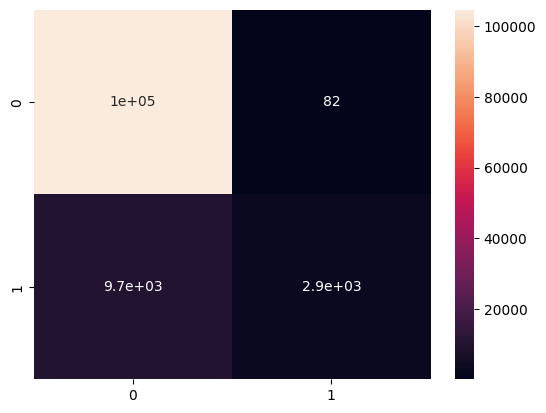

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

sns.heatmap(confusion_matrix_df, annot=True)

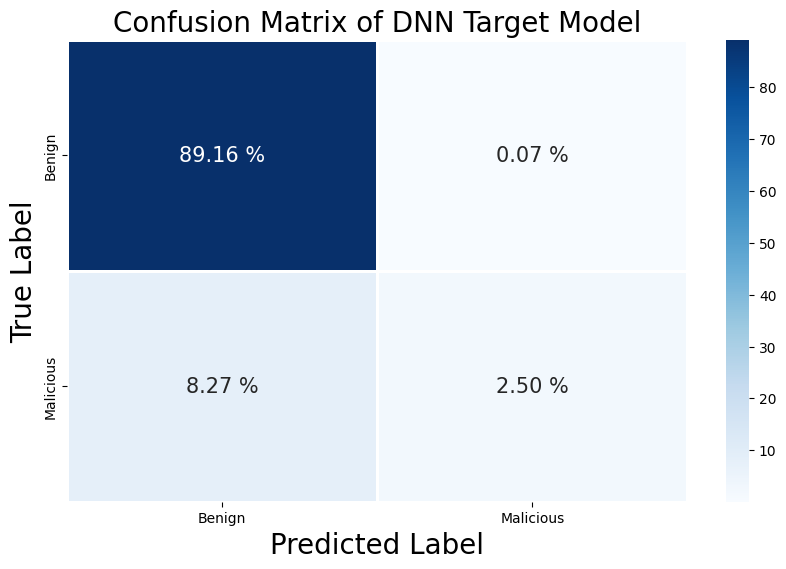

In [24]:
cm = confusion_matrix(y_test, y_pred_list, labels=traindata['Label'].unique() )
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of DNN Target Model', fontsize=20)
plt.show()